In [1]:
#imports
import torch
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue


In [2]:
#import data for a 1000 pairs
N = 1000
(train_input, train_target, train_classes, 
 test_input, test_target, test_classes) = prologue.generate_pair_sets(N)

#change classes to float type
train_classes = train_classes.type(torch.float32)
test_classes = test_classes.type(torch.float32)

#normalize images
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std);


/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor(3.0939)
tensor([5., 4.])
tensor(0)


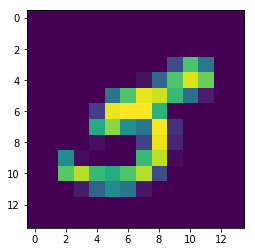

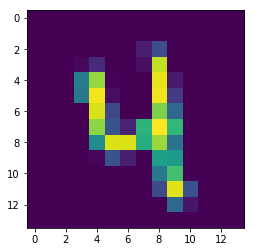

In [3]:
#tests to see what kind of data is there
plt.figure(1)
plt.imshow(train_input[1][0])
print(torch.max(train_input[1][0]))
plt.figure(2)
plt.imshow(train_input[1][1])
print(train_classes[1])
print(train_target[1])

In [4]:
#model, simple cnn with 2 conv layers and one hidden and output layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.fc1(x.view(-1, 64*4)))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    
    eta = 0.01
    
    for e in range(0, 25):
        sum_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        print(e, sum_loss)

In [14]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        for k in range(mini_batch_size):
            if abs(target[b + k].type(torch.int64) - predicted_classes[k]) > 0.9 :
                nb_errors = nb_errors + 1

    return nb_errors

In [7]:
#create torch variables
x_train_1, y_train_1 = Variable(train_input.narrow(1,0,1)), Variable(train_classes.narrow(1,0,1))
x_test_1, y_test_1 = Variable(test_input.narrow(1,0,1)), Variable(test_classes.narrow(1,0,1))

#upsample the images because they are too small
x_train_1 =F.upsample(x_train_1,(28,28), mode='bilinear')
x_test_1 =F.upsample(x_test_1,(28,28), mode='bilinear')

#rearrange shape of target data
#y_train_1 = y_train_1.view(N,1)
#y_test_1 = y_test_1.view(N,1)
mini_batch_size = 100


/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
for k in range(10):
    model = Net()
    train_model(model, x_train_1, y_train_1, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, x_test_1, y_test_1, mini_batch_size)
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / x_test_1.size(0),nb_test_errors, 
                                                     x_test_1.size(0)))

0 163.69905614852905
1 121.94804954528809
2 109.77428197860718
3 94.79667901992798
4 71.36895847320557
5 82.22723913192749
6 64.43965005874634
7 64.52672958374023
8 53.39382457733154
9 48.97477841377258
10 42.48667311668396
11 42.039573669433594
12 31.344369888305664
13 36.70819640159607
14 30.48013973236084
15 35.28259837627411
16 27.89481782913208
17 30.51347041130066
18 26.763903856277466
19 26.46119225025177
20 24.620649218559265
21 23.538941860198975
22 22.51949691772461
23 21.482576847076416
24 20.6643306016922
test error Net 86.70% 867/1000
0 178.40477323532104
1 92.25168943405151
2 109.92426586151123
3 86.47865867614746
4 75.01783752441406
5 85.55538034439087
6 57.90940761566162
7 71.44692611694336
8 59.04917669296265
9 55.6253936290741
10 50.144028663635254
11 42.18734359741211
12 34.17511510848999
13 37.138033628463745
14 32.61828684806824
15 37.64076089859009
16 26.722195148468018
17 33.112106800079346
18 25.925294637680054
19 31.30666172504425
20 23.42319965362549
21 27.109

torch.Size([1, 1, 28, 28])
tensor([2])


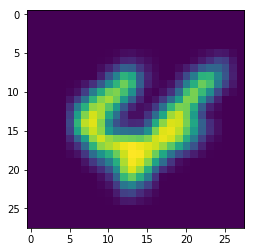

In [16]:
print(x_test_1.narrow(0, 0, 1).shape)
plt.imshow(x_test_1[1][0])
outTest = model(x_test_1.narrow(0, 0, 1))
_, predicted_classes = outTest.data.max(1)
print(y_test_1[1][0].type(torch.int64)-predicted_classes)
